In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

In [4]:
!pip install nba_api
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 9.4 MB/s eta 0:00:00


In [5]:
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22024,1610612738,BOS,Boston Celtics,0022400218,2024-11-13,BOS @ BKN,W,241,139,...,0.708,12,33,45,35,7,6,7,17,25.0
1,22024,1610612738,BOS,Boston Celtics,0022400001,2024-11-12,BOS vs. ATL,L,239,116,...,0.815,6,28,34,28,7,5,20,12,-1.0
2,22024,1610612738,BOS,Boston Celtics,0022400202,2024-11-10,BOS @ MIL,W,240,113,...,0.889,8,34,42,27,5,2,12,16,6.0
3,22024,1610612738,BOS,Boston Celtics,0022400187,2024-11-08,BOS vs. BKN,W,266,108,...,0.842,4,35,39,23,7,9,13,15,4.0
4,22024,1610612738,BOS,Boston Celtics,0022400172,2024-11-06,BOS vs. GSW,L,240,112,...,0.810,13,34,47,22,5,3,12,18,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,21983,1610612738,BOS,Boston Celtics,0028300052,1983-11-05,BOS @ WAS,W,240,120,...,0.778,5,28,33,36,7,7,16,26,NaN
3931,21983,1610612738,BOS,Boston Celtics,0028300043,1983-11-04,BOS vs. IND,W,240,121,...,0.841,11,34,45,28,8,5,22,26,NaN
3932,21983,1610612738,BOS,Boston Celtics,0028300033,1983-11-02,BOS vs. MIL,W,240,119,...,0.816,14,24,38,26,7,7,18,18,NaN
3933,21983,1610612738,BOS,Boston Celtics,0028300019,1983-10-29,BOS @ CLE,W,240,108,...,0.690,13,31,44,25,12,7,13,22,NaN


In [ ]:
games.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')

In [ ]:
games.MATCHUP

0         BOS @ MIL
1       BOS vs. BKN
2       BOS vs. GSW
3         BOS @ ATL
4         BOS @ CHA
           ...     
3928      BOS @ WAS
3929    BOS vs. IND
3930    BOS vs. MIL
3931      BOS @ CLE
3932      BOS @ DET
Name: MATCHUP, Length: 3933, dtype: object

## Tratamento da base

In [6]:
new_Column = [1 if "@" in game else 0 for game in games.MATCHUP]
new_Column
games["Home Court"] = new_Column

In [7]:
games

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home Court
0,22024,1610612738,BOS,Boston Celtics,0022400218,2024-11-13,BOS @ BKN,W,241,139,...,12,33,45,35,7,6,7,17,25.0,1
1,22024,1610612738,BOS,Boston Celtics,0022400001,2024-11-12,BOS vs. ATL,L,239,116,...,6,28,34,28,7,5,20,12,-1.0,0
2,22024,1610612738,BOS,Boston Celtics,0022400202,2024-11-10,BOS @ MIL,W,240,113,...,8,34,42,27,5,2,12,16,6.0,1
3,22024,1610612738,BOS,Boston Celtics,0022400187,2024-11-08,BOS vs. BKN,W,266,108,...,4,35,39,23,7,9,13,15,4.0,0
4,22024,1610612738,BOS,Boston Celtics,0022400172,2024-11-06,BOS vs. GSW,L,240,112,...,13,34,47,22,5,3,12,18,-6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,21983,1610612738,BOS,Boston Celtics,0028300052,1983-11-05,BOS @ WAS,W,240,120,...,5,28,33,36,7,7,16,26,NaN,1
3931,21983,1610612738,BOS,Boston Celtics,0028300043,1983-11-04,BOS vs. IND,W,240,121,...,11,34,45,28,8,5,22,26,NaN,0
3932,21983,1610612738,BOS,Boston Celtics,0028300033,1983-11-02,BOS vs. MIL,W,240,119,...,14,24,38,26,7,7,18,18,NaN,0
3933,21983,1610612738,BOS,Boston Celtics,0028300019,1983-10-29,BOS @ CLE,W,240,108,...,13,31,44,25,12,7,13,22,NaN,1


**Criar sessão spark**

In [26]:
# Create a SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

**Feature Assembling e separando em Treino e Teste**

In [27]:
# Selecionar apenas as colunas relevantes e remover linhas com valores nulos
features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
            'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
            'BLK', 'TOV', 'PF', 'PLUS_MINUS','Home Court']
target = 'PTS'

# Convert your pandas DataFrame 'games' to a Spark DataFrame
games_df = spark.createDataFrame(games)

# # Defina os conjuntos de treino e teste com a condição de data
games_train_df = games_df.filter((col("GAME_DATE") <= "2016-04-14")) \
                   .select(*features, target) \
                   .dropna()
games_test_df = games_df.filter((col("GAME_DATE") > "2016-04-14")) \
                   .select(*features, target) \
                   .dropna()

games_df = games_df.select(*features, target).dropna()

# Criar o VectorAssembler para combinar as features em um vetor
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_transform_train = assembler.transform(games_train_df)
df_transform_test = assembler.transform(games_test_df)

df_transform_train.show()
df_transform_test.show()


+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+----------+----------+---+--------------------+
|MIN|FGM|FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PLUS_MINUS|Home Court|PTS|            features|
+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+----------+----------+---+--------------------+
|240| 37| 86|  0.43|   5|  14|  0.357| 19| 22| 0.864|  10|  29| 39| 20|  7|  3|  7| 20|      10.0|         0| 98|[240.0,37.0,86.0,...|
|240| 34| 89| 0.382|   8|  24|  0.333| 24| 29| 0.828|  13|  33| 46| 17|  6|  1| 12| 17|     -14.0|         0|100|[240.0,34.0,89.0,...|
|241| 40| 90| 0.444|  11|  28|  0.393| 16| 24| 0.667|  10|  30| 40| 26| 10|  6| 15| 21|     -11.0|         1|107|[241.0,40.0,90.0,...|
|239| 44| 78| 0.564|   6|  14|  0.429| 30| 38| 0.789|   4|  30| 34| 35|  6|  9| 14| 23|      15.0|         0|124|[239.0,44.0,78.0,...|
|240| 36| 87| 0.414|  10|  34|  0.294| 22| 27| 0.815|  

**Random Forest**

In [28]:
# Inicializar o modelo Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol=target)

# # Treinar o modelo
model = rf.fit(df_transform_train)

# # Fazer previsões no conjunto de teste
predictions = model.transform(df_transform_test)


# # Mostrar algumas previsões
predictions.select("features", target, "prediction").show(5)

+--------------------+---+------------------+
|            features|PTS|        prediction|
+--------------------+---+------------------+
|[241.0,50.0,93.0,...|139|115.56422128604318|
|[239.0,38.0,75.0,...|116|105.33401597912493|
|[240.0,35.0,86.0,...|113| 99.48668639795548|
|[266.0,39.0,90.0,...|108|  100.873083288012|
|[240.0,38.0,90.0,...|112| 99.21254954685196|
+--------------------+---+------------------+
only showing top 5 rows



**Avaliando o modelo**

In [29]:
# # Avaliar o modelo
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Initialize RegressionEvaluator for MAE
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")

# Calculate MAE
mae = evaluator.evaluate(predictions)

print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 8.932442385271132
Mean Absolute Error (MAE): 7.04398327894958


IGNORE

In [ ]:
X = games[['MIN', 'FGM','FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS','Home Court'
]]  # Variáveis independentes
y = games['PTS']  # Variável dependente (valor que queremos prever)
# # Dividir os dados em treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)

In [ ]:
# Defina os conjuntos de treino e teste com a condição de data
train_Data = games[(games['GAME_DATE'] <= '2016-04-14')]
test_Data = games[(games['GAME_DATE'] > '2016-04-14')]

# Defina sua variável alvo
target_column = 'PTS'

# Divida o conjunto de treino
Y_train = train_Data[target_column]
X_train = train_Data[['MIN', 'FGM', 'FGA', 'FG_PCT',
                      'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
                      'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                      'PLUS_MINUS', 'Home Court']]

# Divida o conjunto de teste
Y_test = test_Data[target_column]
X_test = test_Data[['MIN', 'FGM', 'FGA', 'FG_PCT',
                    'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
                    'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                    'PLUS_MINUS', 'Home Court']]

# Verifique os tamanhos para confirmar que estão correspondentes
print(len(Y_train), len(X_train))
print(len(Y_test), len(X_test))


3058 3058
875 875


## Média movel

In [ ]:
entrada = games[['MIN', 'FGM','FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'
]].head(5).mean()
entrada

MIN           245.0000
FGM            39.2000
FGA            89.4000
FG_PCT          0.4372
FG3M           17.2000
FG3A           52.8000
FG3_PCT         0.3262
FTM            18.2000
FTA            21.6000
FT_PCT          0.8252
OREB            8.8000
DREB           35.6000
REB            44.4000
AST            24.4000
STL             7.2000
BLK             5.0000
TOV            12.8000
PF             16.0000
PLUS_MINUS      8.8000
dtype: float64

In [ ]:
# entrada = entrada.append(pd.Series([1], index=['Home Court']))
entrada['Home Court'] = 1

print([entrada])

[MIN           245.0000
FGM            39.2000
FGA            89.4000
FG_PCT          0.4372
FG3M           17.2000
FG3A           52.8000
FG3_PCT         0.3262
FTM            18.2000
FTA            21.6000
FT_PCT          0.8252
OREB            8.8000
DREB           35.6000
REB            44.4000
AST            24.4000
STL             7.2000
BLK             5.0000
TOV            12.8000
PF             16.0000
PLUS_MINUS      8.8000
Home Court      1.0000
dtype: float64]


## Random Forest

In [ ]:
# Criar o modelo Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Fazer previsões
y_pred = model.predict(X_test)

In [ ]:
# Avaliar o modelo
mse = mean_squared_error(Y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(Y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error: 30.544264657142854
Mean Absolute Error (MAE): 3.7254685714285714


In [ ]:
previsao = model.predict([entrada])
print("Previsão de pts:", previsao[0])

Previsão de pts: 108.7


c:\Users\pedro\anaconda3\envs\projeto\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
pd.DataFrame(X).columns

Index(['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'Home Court'],
      dtype='object')

,Features,Importances
19,Home Court,0.014670
0,MIN,0.026131
15,BLK,0.044900
14,STL,0.047123
18,PLUS_MINUS,0.047235
10,OREB,0.047556
4,FG3M,0.047996
12,REB,0.049185
11,DREB,0.049470
16,TOV,0.049679


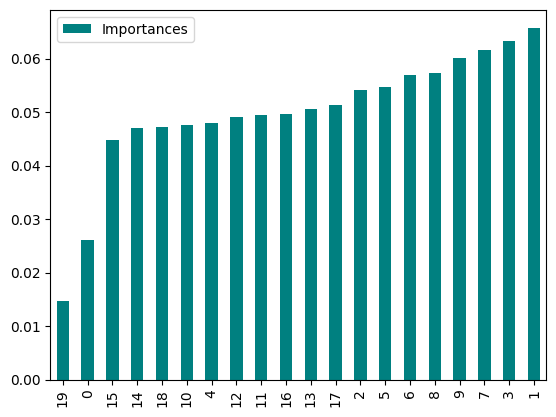

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with your hyperparameters
model = RandomForestClassifier(n_estimators=100)

# Fit the model to the data
model.fit(X, y)

# Get the importance of the resulting features
importances = model.feature_importances_

# Create a data frame for visualization
final_df = pd.DataFrame({'Features': pd.DataFrame(X).columns, 'Importances': importances})
final_df.set_index('Importances')

# Sort in ascending order for better visualization
final_df = final_df.sort_values('Importances')

# Plot the feature importances in bars
final_df.plot.bar(color='teal')

final_df